# Cohort 400 ratios AUCs analysis

### Imports and environment setup

- Date of run: 2024-08-20
- Environment: python 3.12
- Packages required: pandas, numpy, sklearn, statsmodels, seaborn, matplotlib

In [1]:
# Include in the environment the code directory with the utils function
import sys
sys.path.append('../code/')

In [2]:
# Library imports
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Utils imports
import cohort_analysis_utils as utils
import ms_utils

In [3]:
# Remove warnings for readability
import warnings
warnings.filterwarnings('ignore')

# Remove cell printing limits
pd.set_option('display.max_rows', None)

# Data loading and preprosessing

For this analysis, we are going to work with the MS ratios file ─located at ["data/ms/Womec_targetedDIA_ratio.csv"](<../data/ms/Womec_targetedDIA_ratio.csv>)─. In the same folders there are files for MS areas, untargeted MS, metadata from the patients and protein data.

In [4]:
METADATA_PATH = '../data/ms/Womec_DIA_patients.csv'
WOMEC_DIA_PATH = '../data/ms/Womec_targetedDIA_ratio.csv'
PROTEIN_DATA_PATH = '../data/ms/Womec_DIA_protein_data.csv'

# Key field to link the metadata with the WOMEC data
KEY_COLUMN = 'filename_womec'


In [5]:
# Load, harmonize and merge the data with the metadata
df_400 = ms_utils.load_data_with_metadata(WOMEC_DIA_PATH, METADATA_PATH, KEY_COLUMN)

In [6]:
# Different peptides for the same protein will have the same column name, rename then as _0, _1, _2, etc.
df_400 = ms_utils.rename_duplicated_columns(df_400)

In [7]:
# Ensure categorical columns are treated as such
df_400 = utils.cols_as_category(df_400, {'Condition':{'Benigna': 0, 'EC': 1, 'Sarcoma uterino': 1}})

In [8]:
# Define the biomarkers columns
BIOMARKERS_400 = list(df_400.columns[17:])

In [9]:
# Ensure numerical columns are treated as such
df_400 = utils.cols_as_numbers(df_400, BIOMARKERS_400)

In [10]:
# We load in a separate dataframe the protein data
df_protein_data = pd.read_csv(PROTEIN_DATA_PATH, sep='\t', index_col='Genes', header=0)

# Computing the models

In [11]:
# General params
RESULTS_PATH = '../data/results/400'

We will consider only the biomarkers with at least 100 samples for Benign and Cancer conditions with an individual AUC of at least 0.65

In [12]:
# Load the results
df_400_results_direct_max_1 = pd.read_csv(f'{RESULTS_PATH}/direct/max_1.csv', sep=',', index_col=0, header=0)

In [13]:
# Filter out the models that are not significant
BEST_BIOMARKERS = []

for biomarker in df_400_results_direct_max_1.index:
    if df_400_results_direct_max_1.loc[biomarker, 'AUC'] > 0.65:
        # Require the biomarker to appear in at least 100 samples of each condition
        if df_400[df_400['Condition'] == 1][biomarker].notna().sum() > 100 and (df_400[df_400['Condition'] == 0][biomarker].notna()).sum() > 100:
            BEST_BIOMARKERS.append(biomarker)

In [14]:
print(f"{len(set([bmk.split('_')[0] for bmk in BEST_BIOMARKERS]))} biomarkers have an AUC > 0.65 and appear in at least 100 samples of each condition")

79 biomarkers have an AUC > 0.65 and appear in at least 100 samples of each condition


We will consider for computing biomarker ratios only the relevant biomarkers (those with AUC > 0.65 and 100 for each condition)

In [15]:
# This is costly, so is commented out to compute it only once

# _ = utils.compute_all_models_and_save(df=df_400, 
#                                       biomarkers=BEST_BIOMARKERS, 
#                                       target_col='Condition', 
#                                       methods=['biomarker_ratio'], 
#                                       max_biomarker_count=2,
#                                       folder_name=RESULTS_PATH)

# Results

Expectedly, as was happening with the usual AUC analysis, the biomarkers ratios with best performance are those with oposite tendencies. But in this scenario, they present slightly smaller AUCs than the classical models.

In [22]:
# Show the results
df_400_results_direct_max_2 = pd.read_csv(f'{RESULTS_PATH}/biomarker_ratio/max_2.csv', sep=',', index_col=0, header=0)
df_400_results_direct_max_2.head(15)

,Biomarker_2,AUC,Sensitivity,Specificity,NPV,PPV,Best_Threshold
Biomarker_1,,,,,,,
TARS1_2,DCN_1,0.87482,0.95067,0.35915,0.82258,0.69967,0.52525
LDHA_0,DCN_0,0.87143,0.95413,0.25547,0.77778,0.67097,0.58586
LDHA_0,DCN_1,0.87114,0.96000,0.20408,0.76923,0.64865,0.57576
TARS1_2,ACE_0,0.87112,0.95575,0.30986,0.81481,0.68790,0.53535
FASN,DCN_1,0.87071,0.96818,0.21805,0.80556,0.67192,0.51515
AGRN_0,ACE_0,0.87063,0.96000,0.44361,0.86765,0.74483,0.59596
PKM_0,DCN_1,0.87023,0.95982,0.19444,0.75676,0.64955,0.58586
FASN,ACE_0,0.86876,0.95023,0.30827,0.78846,0.69536,0.53535
FASN,DCN_0,0.86863,0.96651,0.20000,0.78125,0.66887,0.51515


<Axes: xlabel='DCN_1', ylabel='Count'>

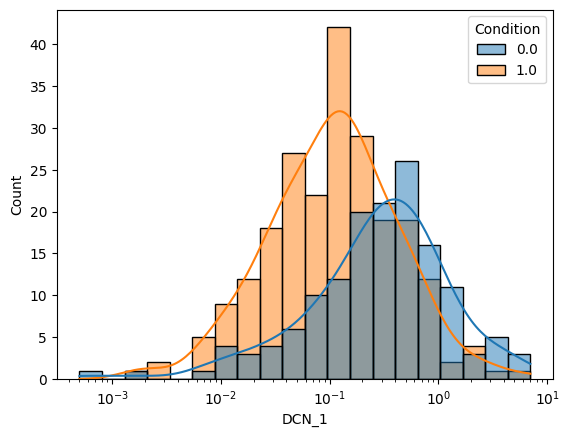

In [17]:
sns.histplot(df_400, x='DCN_1', hue='Condition', bins=20, kde=True, log_scale=True)


<Axes: xlabel='TARS1_2', ylabel='Count'>

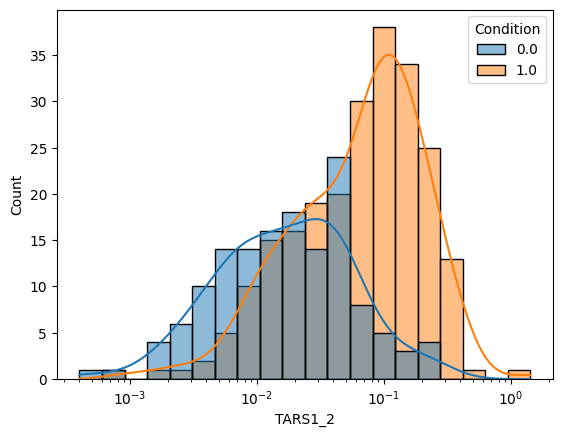

In [23]:
sns.histplot(df_400, x='TARS1_2', hue='Condition', bins=20, kde=True, log_scale=True)